---

## ChestXRAY Model - Desenvolvimento utilizando CNN 

### Objetivo
O objetivo do trabalho é criar uma rede neural convolucional que seja capaz de classificar imagens de
Raio X em ‘**normal**’, ‘**pneumonia bacterial**’ ou ‘**pneumonia viral**’.

---

## Documentação base

 **OBS:** *alguns comentários são adicionados no decorre do código para explica/auxiliar no entendimento do respectivo trecho*

### Mudança no layout
O nome dos diretórios, assim como o nome das imagens foram alterados/ajustadas para ficar com a estrutura mais limpa e organizada facilitando o uso ao ser manipulados no Python.


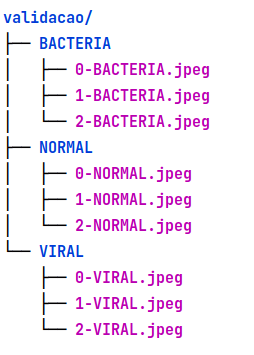

---

### Hyperparamtros


Valor referente ao tamanho das imagens (para processamento)
+ **imageSize = 224**

Coeficiente inicial para calcular do Stochastic Gradient Descendent 1e-4 = 0.0001
+ **INIT_LR = 1e-4**

Quantidade de treinamento da rede neural (número ideal obtido com base em vários testes)
+ **EPOCHS = 20**

(batch size) Valor maior que 1 e divisivel pelo tamanho total do dataset
+ **BS = 40**





### Array de ordenação das classes a nivel do Python

No que refere-se a classificação segue com a ordenação (*Array Python*) **NORMAL**, **PNEUMONIA BACTERIA** E **PNEUMONIA VIRAL**


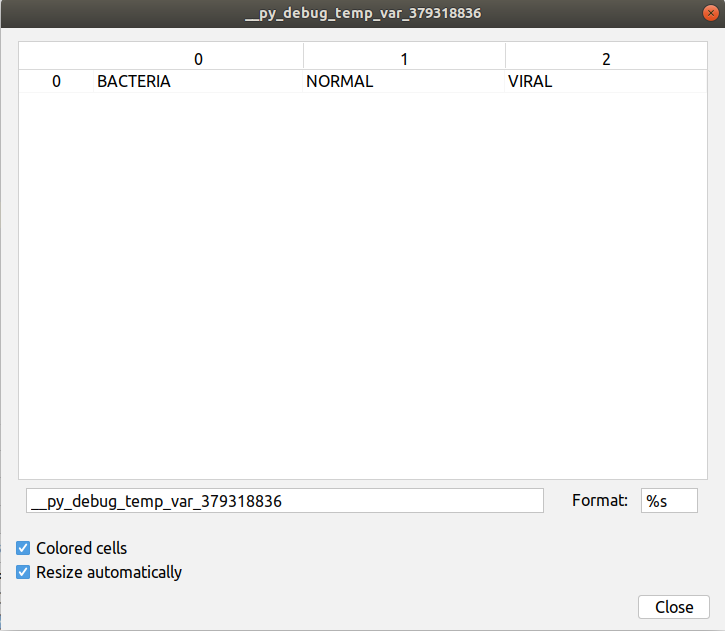


### Acurácia

A acurácia final atingida foi de *82%*, considerando as caracteristicas do dataset e a distinção das classes o resultado atingiu um número expressivo

O tempo total de processamento considerando as 20 EPOCS foi de **18min e 40 seg** utilizando uma maquina (notebook) Core i7 9° geração (12 nucleos)

**OBS:** *esse tempo foi obtido rodando o script python via IDE PyCharm e via Terminal Linux (linha de comnando), porém executando o mesmo source python no Jupyter Notebook demorou o dobro do tempo*



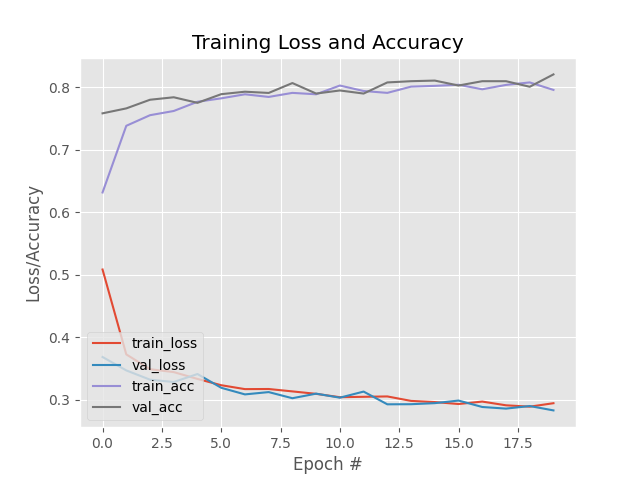

---

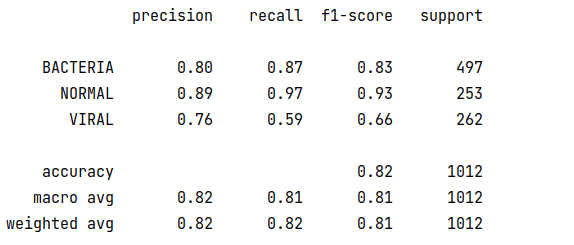


### Confusion Matrix

A matriz de confusão gerada revela que a capacidade de predição do modelo para a classe **NORMAL** beira os 98%, na contra mão dessa perfomance, predição da classe **VIRAL** tem um alto indice de erros associados a classe *BACTERIA*, uma possível causa para esse problema pode ser o nivel de ruido das imagens outo ponto que vale ressaltar é tamanho do dataset (*talvez um número maior de imagens poderia influenciar de forma positiva na predição do modelo*), por fim a classe **BACTERIA** tem uma boa performance.

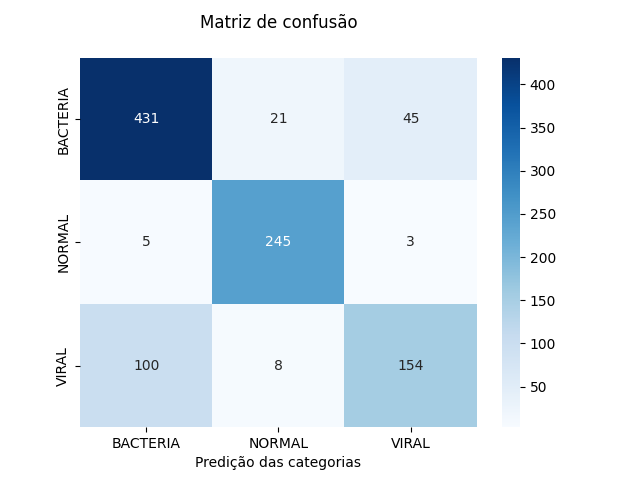

---


## Excução da rede 

### Pre requisito

Instalar as bibliotecas executando seguinte comando

+ pip install -r requirements.txt

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from imutils import paths
import glob as glb
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import os

## Classificador ChestXRAY

O processo de classificação esta organizado em alguns metodos Python, abaixo será descriminado a função de cada um deles.

O método abaixo **classification()** recebe a imagem a ser processada, faz a classificação, formata o resultado final e expoe como saida do processamento.
Esse ciclo ocorre para cada imagem lida nos diretórios das classes (*NORMAL, BACTERIA E VIRAL*)

In [10]:
def classification(image_path, dir_name):
    IMAGE_SIZE = 224
    image = load_img(image_path,
                     target_size=(
                     IMAGE_SIZE, IMAGE_SIZE))  
    
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    index = np.argmax(predictions)
    
    print("[INFO] Classificando as imagens do diretório: {}".format(dir_name))

    if(index == 0):
        print("::RaioX Analisado: {}".format(dir_name))
        print("Classificado como: {}".format(LABELS[index]))
        print(":::::::::Acurácia: %.2f" % predictions[0][index])
        print("--------------------------------------------------------------------")
    elif(index == 1):
        print("::RaioX Analisado: {}".format(dir_name))
        print("Classificado como: {}".format(LABELS[index]))
        print(":::::::::Acurácia: %.2f" % predictions[0][index])
        print("--------------------------------------------------------------------")
    else:
        print("::RaioX Analisado: {}".format(dir_name))
        print("Classificado como: {}".format(LABELS[index]))
        print(":::::::::Acurácia: %.2f" % predictions[0][index])
        print("--------------------------------------------------------------------")



Quanto ao método **get_images_validation()** ele é responsável por obter cada imagem dos diretórios de cada classe e repassa-lo para o metodo **classification()**, isso garante que cada imagem será lida de acordo com o respectivo diretório.

In [11]:
def get_images_validation(dir):
    path = PATH_VALIDATION + dir + FORMAT

    for image in glb.glob(path):
        classification(image, dir)

Por fim o metodo **get_dir_validation()** captura e seguimenta a chamada de cada diretório.

In [12]:
def get_dir_validation():
    for dir in DIRETORIOS:
        get_images_validation(dir)

---

#### Bloco principal no qual contém as constantes e a chamada do método que iniciar o ciclo de classificação das imagens


OBS: Cada vez que um novo treino é executado o .model gerado é salvo na raiz do diretório src
para fim de demonstração dos resultados, optou-se por copiar o modelo com a acurácia de 82% para o
diretório abaixo
PATH_VALIDATION = "../dataset/chest_xray/validacao/"


In [13]:
if __name__ == '__main__':
    
    # Constantes e variáveis
    NORMAL = "NORMAL"
    PNEUMONIA_BACTERIA = "PNEUMONIA_BACTERIA"
    PNEUMONIA_VIRAL = "PNEUMONIA_VIRAL"
    LABELS = ['BACTERIA', 'NORMAL', 'VIRAL']
    PATH_VALIDATION = "../dataset/chest_xray/validacao/"
    DIRETORIOS = ['BACTERIA/', 'NORMAL/', 'VIRAL/']
    FORMAT = "*.jpeg"

    print("[INFO] Carregando o modelo para realizar a predição ...")
    model = load_model("../model/chestxray_3C.model")
    
    #Método responsável por obter os diretórios de cada classe de imagens
    get_dir_validation()

[INFO] Carregando o modelo para realizar a predição ...
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: NORMAL
:::::::::Acurácia: 0.56
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.64
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: VIRAL
:::::::::Acurácia: 0.53
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.79
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acu

[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.81
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.67
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.90
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.85
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.70
---------------------------------------

[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.94
--------------------------------------------------------------------


[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.99
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.99
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.99
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: VIRAL/
::RaioX Analisado: VIRAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.92
--------------------------------------------------------------------
[I

---

## Início dos métodos utilizados no treinamento do modelo

---

#### Data Augmentation
O recurso Data Augmentation foi utilizado nesse projeto com a finalidade de prover mais dados, nesse caso mais imagens para ajudar o modelo a obter uma melhor resultado em seu treinamento.
O uso do data augmentation influenciou de forma positiva a capacidade do modelo de fazer classificações.


In [2]:
def dataAugmentatio():
    aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    return aug

---

#### Arquitetutra a rede CNN


Foi escolhido o mobileNet2 (Keras/Tensorflow), ela uma rede CNN que tem como caracteristica promover uma melhor performance quando é utilizanda em dispositivos moveis, isso pensando na capacidade limitade de um dispositivo movel
se comparado a de um servidor.

A MobileNetV2 e baseada em inverted residual structure de modo que as conexoes residuais estajam entre as camadas bottleneck layers.

As camadas de expansões intermediarias utilizam convoluções lightweight e  depthwise  para filtrar os recursos do não-lineares, por definição a arquitetura da MobileNetV2 contem a camada inicial de convolução com 32 filtros seguido por 19 residuals bottleneck layers

https://arxiv.org/abs/1801.04381

A implementação abaixo, define/Carrega a arquitetura(parâmetros) base da rede, de modo que o re-shape das imagens seguem o padrão de tamanho 224x224 pixels, com pool_size de 3x3, 128 neurônios em sua camada mais profunda, dropout de 20% (ou seja o neurônio que atingir um peso abaixo de 20% não será enviado para a próxima camada), por fim, definimos 3 neurônios/classses de saída



In [3]:
def baseModelArc():
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
                            input_tensor=Input(shape=(224, 224, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)

    # Criando o Modelo ( Loop sobre todos os  layers no modelo base onde eles não iram ser atualizados durante o primeiro treinamento )
    model = Model(inputs=baseModel.input, outputs=headModel)

    return model, baseModel

#### O método trainingModel() executa do treinamento do modelo

In [4]:
def trainingModel(aug, model, trainX, trainY, testX, testY):
    H = model.fit(
        aug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)
    return H

#### Método responsável por compilar/criar um plot dos dados do processamento (acurácia)

In [5]:
def plotMetrics(H):
    N = EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.figure()
    plt.show("plot.png")

#### Método responsável por compilar/criar um plot da Matriz de Confusão

In [6]:
def confusionMatrix(testY, predIdxs):

    test_Y = np.argmax(testY, axis=1)
    cf_matrix = confusion_matrix(test_Y, predIdxs)
    heat_map = sb.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="d")
    heat_map.set_title('Matriz de confusão\n');
    heat_map.set_xlabel('Predição das categorias\n\n')
    heat_map.xaxis.set_ticklabels(['BACTERIA', 'NORMAL', 'VIRAL'])
    heat_map.yaxis.set_ticklabels(['BACTERIA', 'NORMAL', 'VIRAL'])
    plt.savefig("matrix_de_confusao.png")

#### Metodo principal no qual contem a junção de todos os blocos/metodos (comentários no decorrer do código)

In [7]:
def training(imagePaths, imageSize, data, labels):
    print("[INFO] Carregando as imagens para processamento ...")

    for imagePath in imagePaths:
        
        label = imagePath.split(os.path.sep)[-2]
        image = load_img(imagePath,
                         target_size=(imageSize, imageSize))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(label)

    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    
    # cria uma matriz das labels binarias
    labels = to_categorical(labels)

    # Separa os dados para treino e test, nesse caso a porcentagem é 80(treino)/20(teste)
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                      test_size=0.20, stratify=labels, random_state=42)
    # Data Augmentation
    aug = dataAugmentatio()

    # Cria a arquitetura base do modelo
    model, baseModel = baseModelArc()

    for layer in baseModel.layers:
        layer.trainable = False

    # Compilação do modelo
    print("[INFO] Compilando o modelo...")
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

    plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR", expand_nested=True, dpi=True)

    # Treinamento do Modelo (train the head of the network)
    print("[INFO] Utilizando data augmetation no treinamento do modelo ...")
    H = trainingModel(aug, model, trainX, trainY, testX, testY)

    # Executa Testes de Predição
    print("[INFO] Avaliando a rede (executando os testes de predição) ...")
    predIdxs = model.predict(testX, batch_size=BS)

    # Para cada imagem no set de teste procuramos o index da label no qual contem a maio probabilidade de predição
    predIdxs = np.argmax(predIdxs, axis=1)

    print("[INFO] Gerando a Matrix de confusão")
    confusionMatrix(testY, predIdxs)

    print("[INFO] Exibindo os dados da classificação formatados ...")
    print(classification_report(testY.argmax(axis=1), predIdxs,
                                target_names=lb.classes_))
    # Grava o modelo no formato .H5
    print("[INFO] Salvando o modelo de detecção de Raio-X ...")
    model.save("chestxray_3C.model", save_format="h5")

    # Plotagem dos dados de treinamento
    plotMetrics(H)

### Bloco principal no qual contém constantes e a chamada do método que iniciar o ciclo de treinament, geração do modelo final de classificação


[INFO] Carregando as imagens para processamento ...
### Categorias/classes em forma de matriz:  [1 1 1 ... 2 2 2]
[INFO] Compilando o modelo...
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.589685 to fit

[INFO] Utilizando data augmetation no treinamento do modelo ...
Epoch 1/20
101/101 [==============================] - 94s 930ms/step - loss: 0.4742 - accuracy: 0.6651 - val_loss: 0.3835 - val_accuracy: 0.7342
Epoch 2/20
101/101 [==============================] - 94s 932ms/step - loss: 0.3764 - accuracy: 0.7352 - val_loss: 0.3333 - val_accuracy: 0.7806
Epoch 3/20
101/101 [==============================] - 89s 882ms/step - loss: 0.3480 - accuracy: 0.7577 - val_loss: 0.3196 - val_accuracy: 0.7866
Epoch 4/20
101/101 [==============================] - 89s 877ms/step - loss: 0.3428 - accuracy: 0.7639 - val_loss: 0.3182 - val_accuracy: 0.7895
Epoch 5/20
101/101 [==============================] - 88s 872ms/step - loss: 0.3326 - accuracy: 0.7744 - val_loss: 0.3040 - val_accu

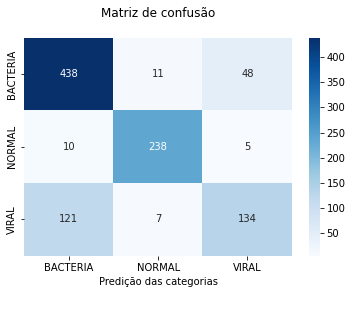

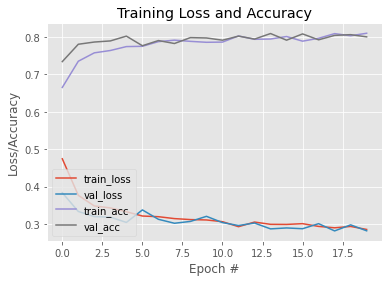

<Figure size 432x288 with 0 Axes>

In [8]:
if __name__ == '__main__':

    # Objetos e constantes
    PATH_TRAIN = "../dataset/chest_xray/treinamento"
    imagePaths = list(paths.list_images(PATH_TRAIN))
    data = []
    labels = []

    # Hiperâmetros
    imageSize = 224
    INIT_LR = 1e-4 
    EPOCHS = 20
    BS = 40

    training(imagePaths, imageSize, data, labels)

## SEARCH
### Links gerais
https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8

https://www.hindawi.com/journals/mpe/2021/3366057/

https://www.radiologymasterclass.co.uk/gallery/galleries

https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/98498

https://www.tensorflow.org/tutorials/keras/classification#import_the_fashion_mnist_dataset

### R-CNN
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet152

### GitHub
https://github.com/omrifried/RSNA-Chest-X-Ray-Faster-RCNN/blob/main/rsna-pneumonia-faster-rcnn-detection.ipynb

https://github.com/arindam93/Chest-X-ray-Disease-Diagnosis-using-Faster-R-CNN

https://github.com/Vedant-S/Mask-RCNN_Instance-Segmentation

https://github.com/WenQingLee/maskrcnn-xray